**Contexte** : dans le cadre d'analyse de données d'un dataset qui répertorie les anomalies de température terrestre, le but de ce notebook est de choisir un modèle de prédiction, observer les features et enfin prédire les anomalies jusqu'en 2050

### Modélisation par regression - choix du modèle

In [1]:
import pandas as pd
import numpy as np
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('datas (1).csv')

In [3]:
df = df.drop('iso_code', axis=1) # suppression de la colonne ISO-CODE

target = df['temp_anomaly']
data = df.drop('temp_anomaly', axis=1)

In [4]:
X, y = data, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)# fit all models
reg = LazyRegressor(predictions=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:03<00:00, 12.83it/s]


In [5]:
models.style.background_gradient(axis=None, low=0.7, high=1.0, cmap='RdYlGn')

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.709929,0.740235,0.299489,0.169391
AdaBoostRegressor,0.705091,0.735902,0.301976,0.081517
LGBMRegressor,0.697689,0.729274,0.305743,0.041124
RandomForestRegressor,0.686588,0.719333,0.311306,0.355857
ExtraTreesRegressor,0.685919,0.718734,0.311638,0.217393
BaggingRegressor,0.685858,0.718679,0.311668,0.047473
HistGradientBoostingRegressor,0.682874,0.716007,0.313145,0.161564
MLPRegressor,0.676389,0.710199,0.316330,0.162189
KNeighborsRegressor,0.668302,0.702957,0.320258,0.015009


Selection du model XGB pour la suite.

#### Visualisation des données par classe de température

In [6]:
df['temp_anomaly'].describe()

count   672.00
mean      0.20
std       0.58
min      -1.29
25%      -0.21
50%       0.08
75%       0.54
max       2.22
Name: temp_anomaly, dtype: float64

In [7]:
df['classes'] = pd.cut(df['temp_anomaly'], bins=4, labels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4'])

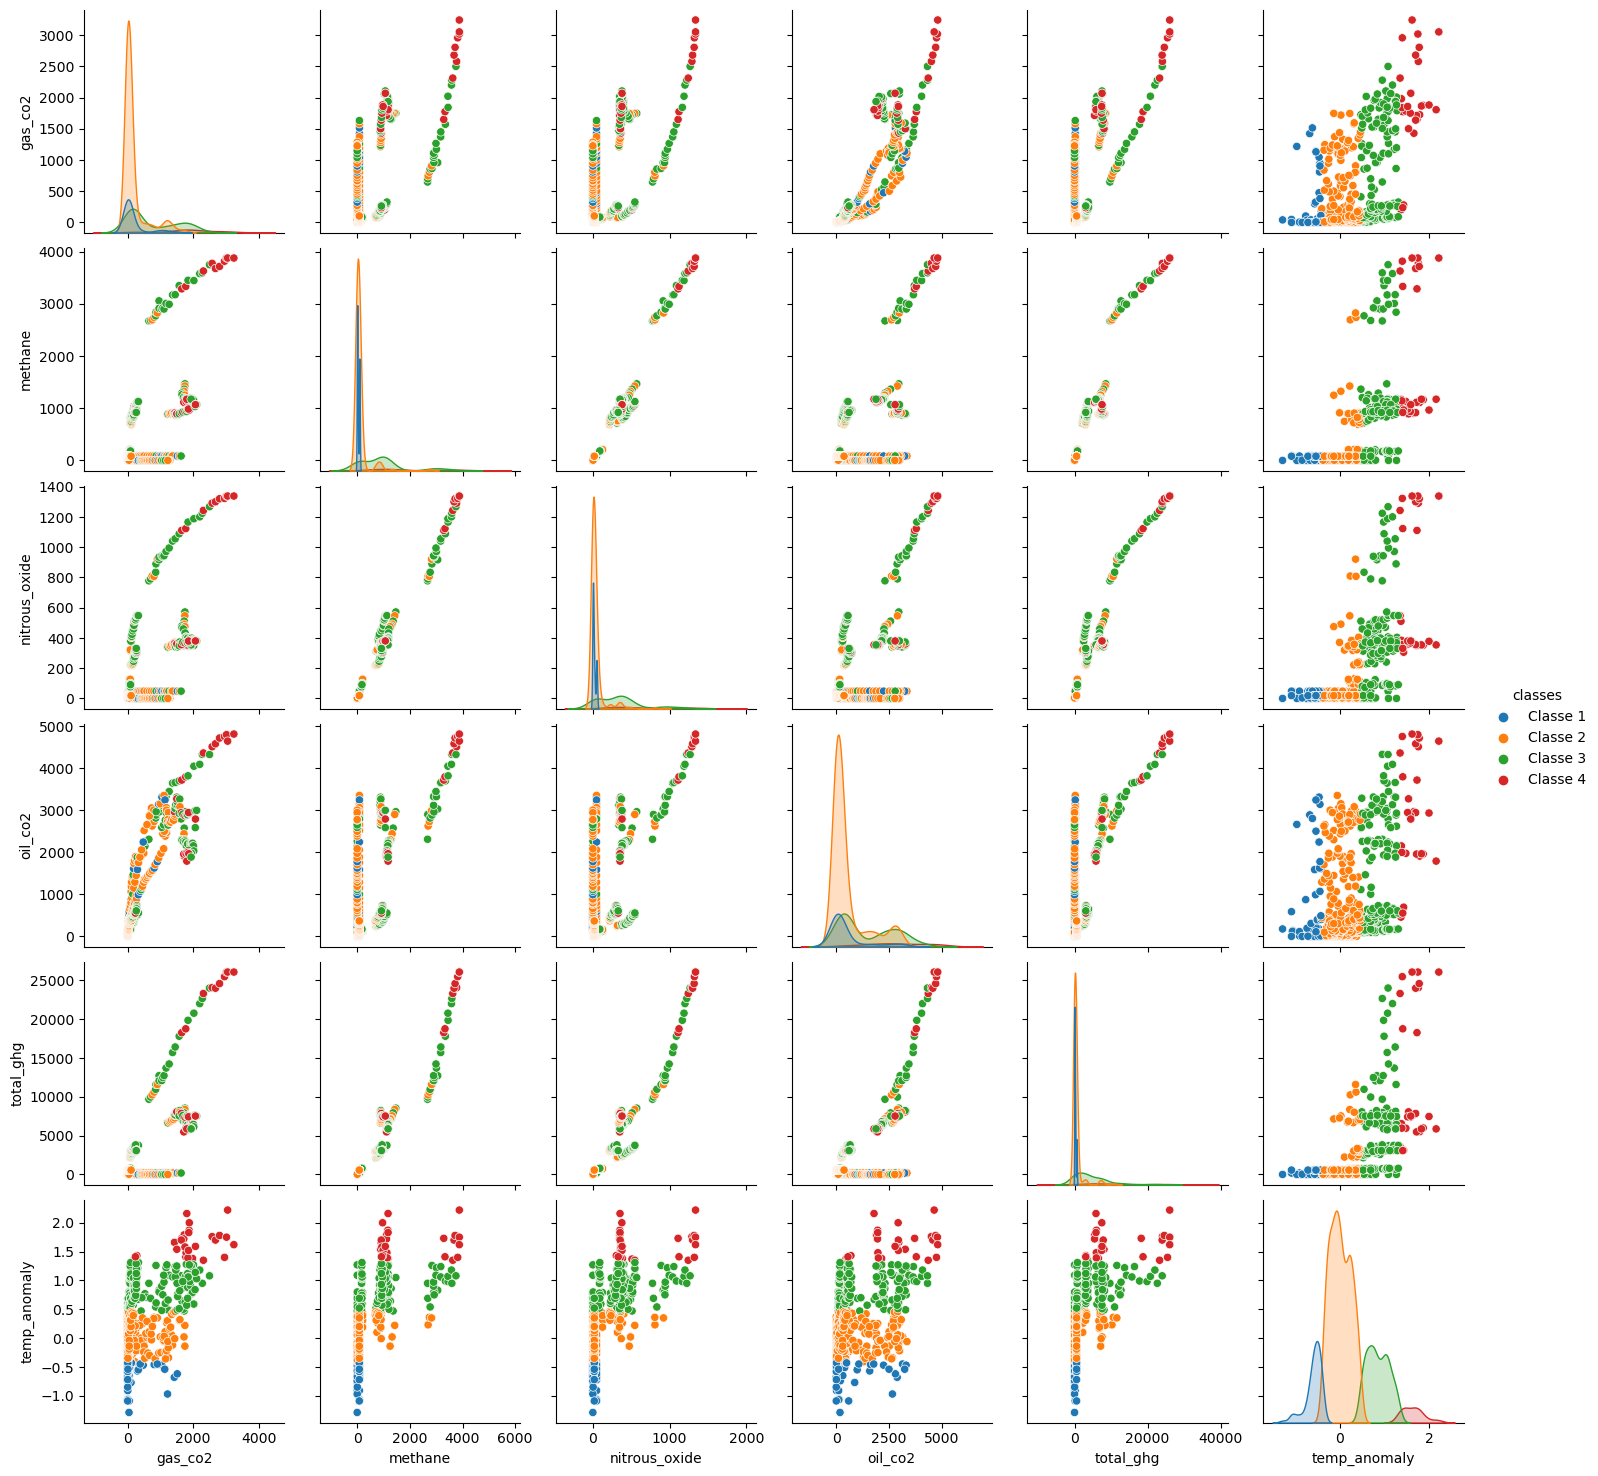

In [8]:
# observation du dataset sur un graphique des 6 dernière colonnes
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
sns.pairplot(data=df[df.columns[-7:]], hue='classes');

### Entrainement du modele

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         672 non-null    object 
 1   year            672 non-null    int64  
 2   population      672 non-null    float64
 3   gdp             672 non-null    float64
 4   cement_co2      672 non-null    float64
 5   co2             672 non-null    float64
 6   co2_per_capita  672 non-null    float64
 7   coal_co2        672 non-null    float64
 8   flaring_co2     672 non-null    float64
 9   gas_co2         672 non-null    float64
 10  methane         672 non-null    float64
 11  nitrous_oxide   672 non-null    float64
 12  oil_co2         672 non-null    float64
 13  total_ghg       672 non-null    float64
dtypes: float64(12), int64(1), object(1)
memory usage: 73.6+ KB


In [10]:
# mise en forme des features
features = pd.get_dummies(data, columns=data.select_dtypes(exclude=['int64', 'float64']).columns)

In [11]:
X.shape[0], y.shape[0]

(672, 672)

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

X = features
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)  # Ajustez la taille du test selon vos besoins

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [13]:
y_pred = model.predict(X_test)

In [14]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 0.3430030759796817


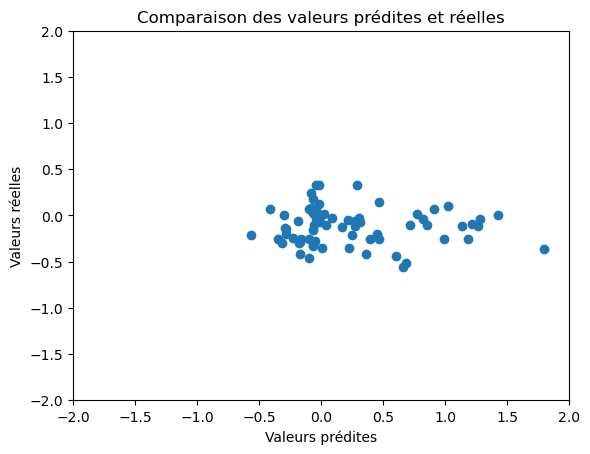

In [15]:
import matplotlib.pyplot as plt

y_true = target[:len(y_pred)]  # Tronquez ou filtrez les valeurs de y_true pour correspondre à la dimension de y_pred

plt.scatter(y_pred, y_true)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Comparaison des valeurs prédites et réelles')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

### Explication du modèle à l'aide de SHAP

In [16]:
# !pip install shap # A utiliser uniquement si shap n'est pas disponible dans l'environnement
import shap

In [17]:
# Instanciez un explorateur SHAP avec votre modèle
explainer = shap.Explainer(model)

# Calculez les valeurs SHAP pour vos données d'entraînement
shap_values = explainer.shap_values(X_train)

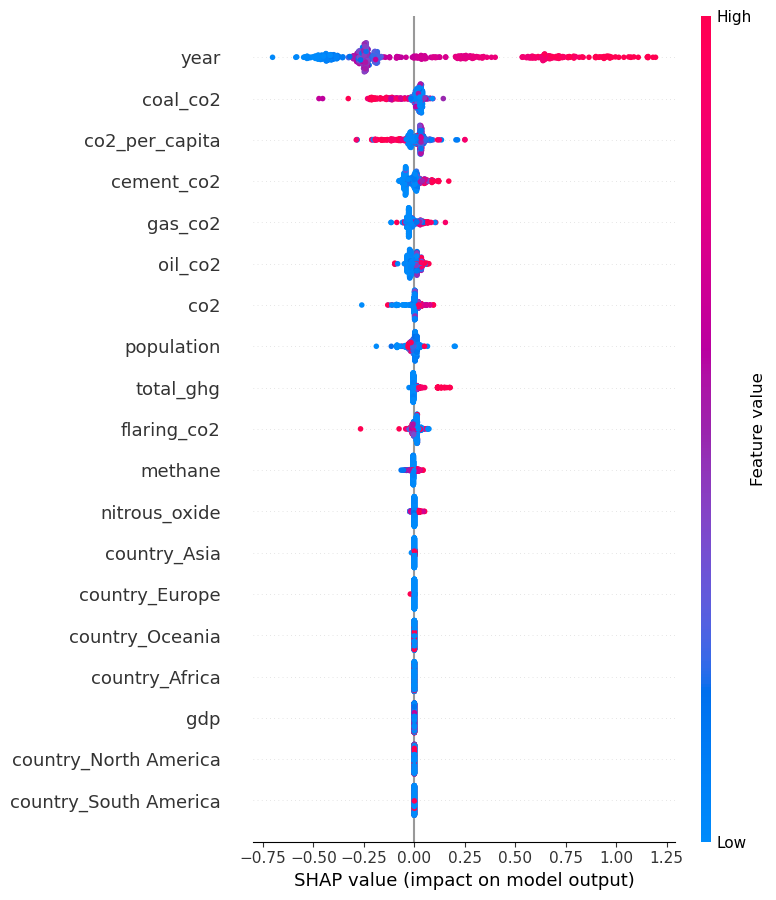

In [18]:
# Calculez les valeurs SHAP pour toutes les données d'entraînement
shap_values = explainer.shap_values(X_train)

# Affichez les explications des fonctionnalités pour toutes les données d'entraînement
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

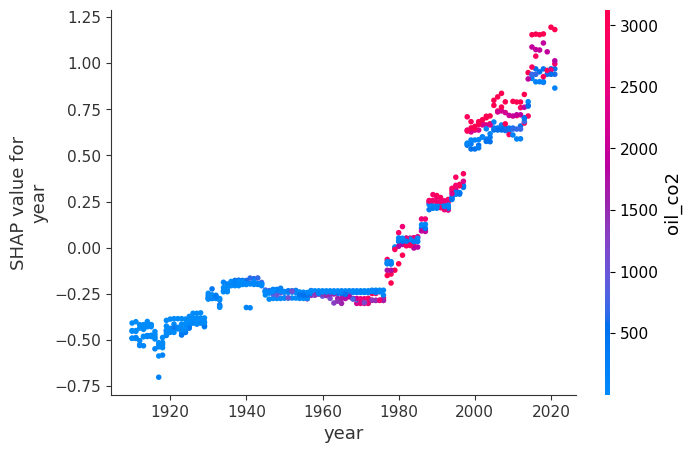

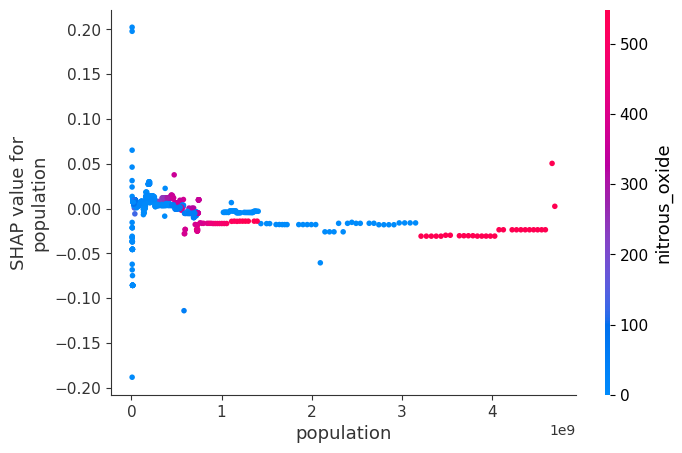

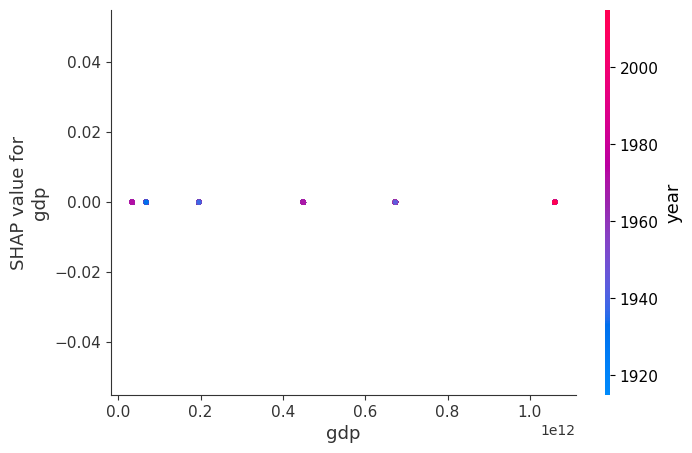

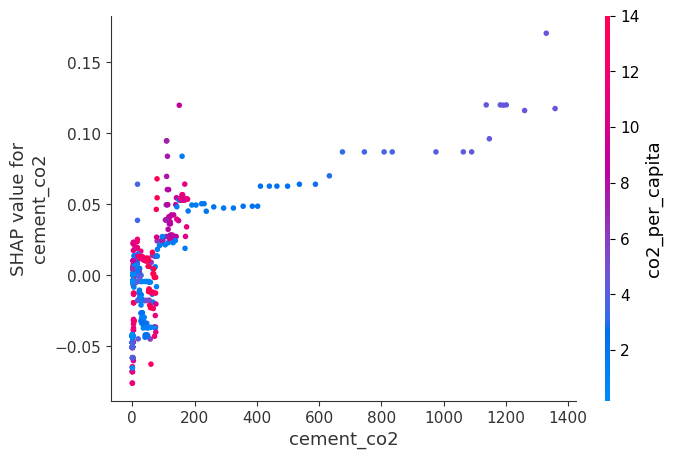

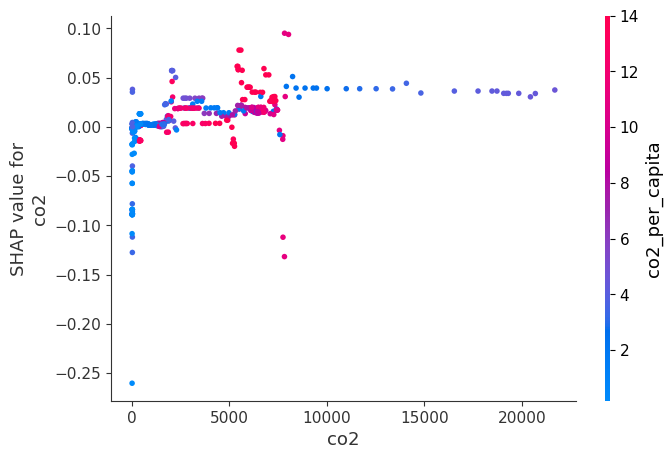

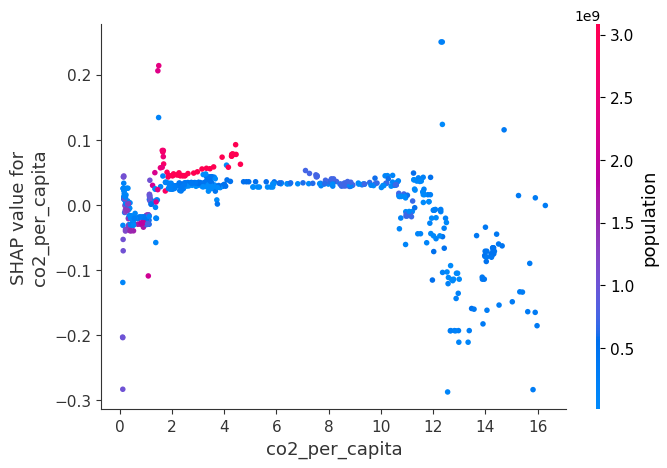

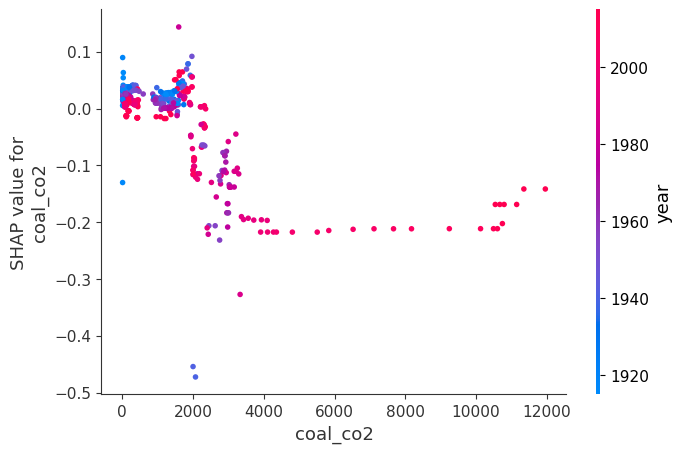

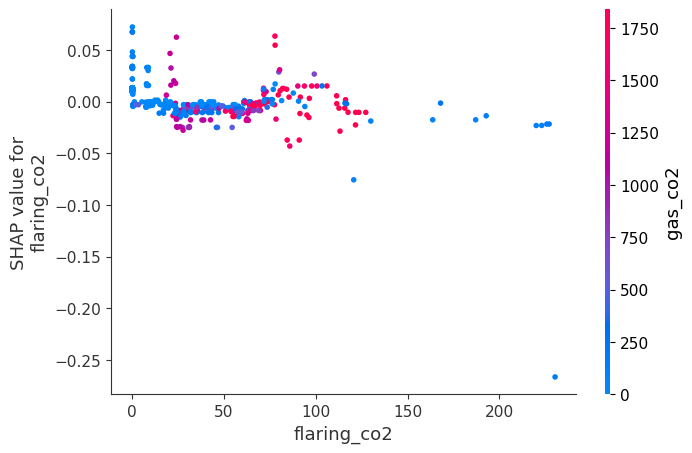

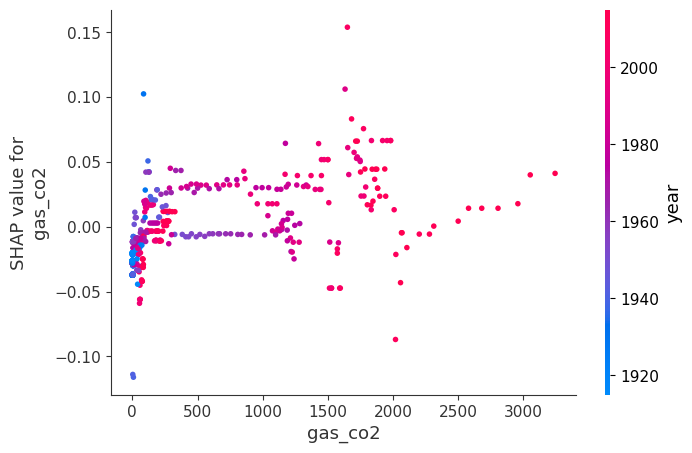

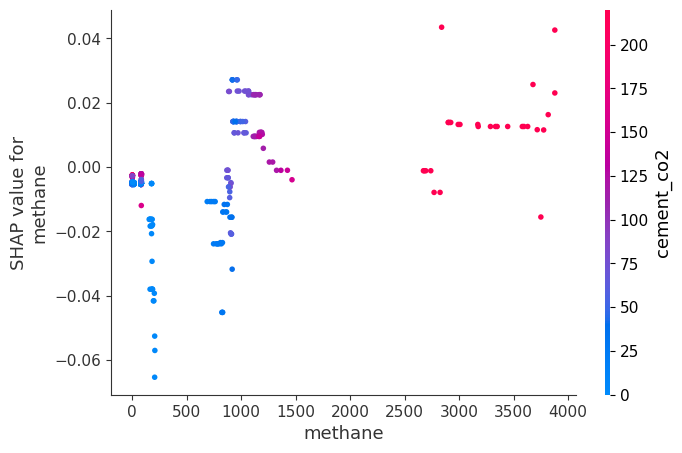

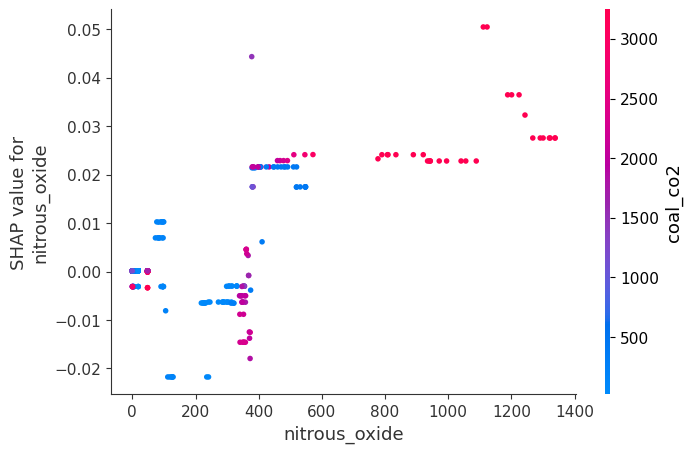

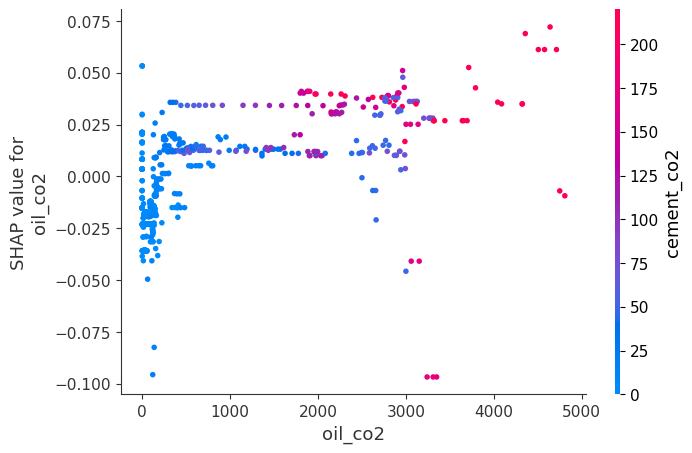

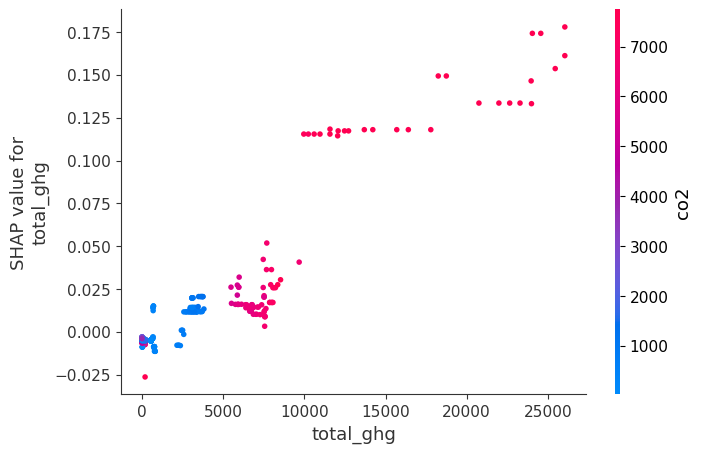

In [19]:
# diagramme de dépendance
for features in X_train.columns[:-6]:
    shap.dependence_plot(features, shap_values, X_train)

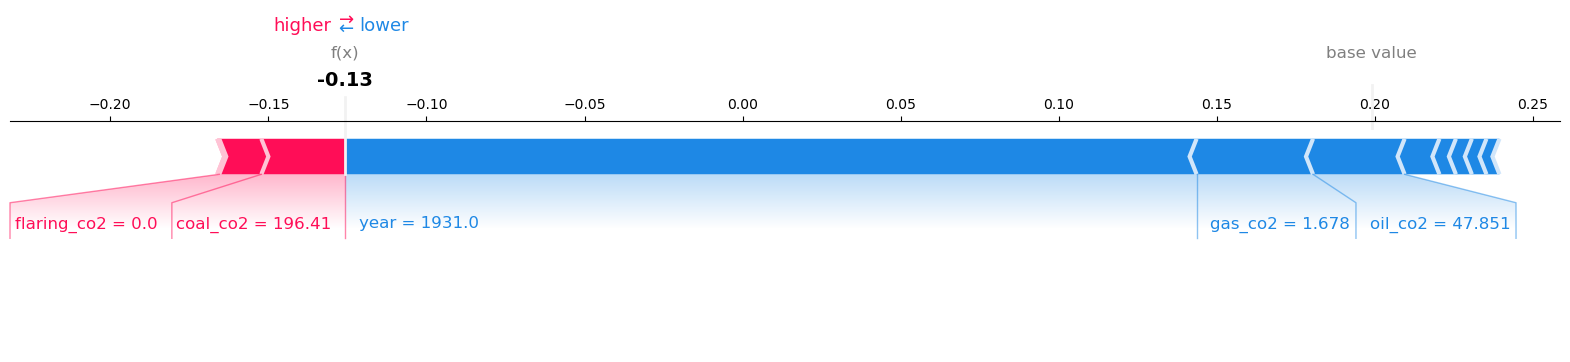

In [20]:
# Sélectionner l'indice de l'observation spécifique
index_observation = 1

shap.force_plot(explainer.expected_value,
                shap_values[index_observation, :],
                X_train.iloc[index_observation, :],
                feature_names=X_train.columns, matplotlib=True)

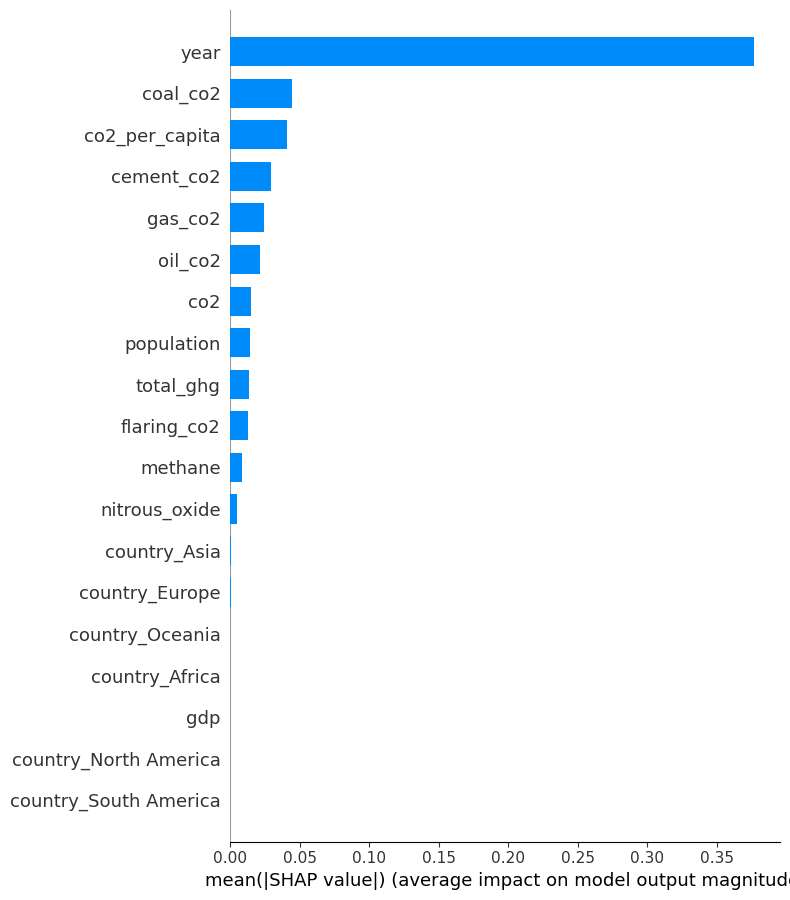

In [21]:
# features importances
shap.summary_plot(shap_values, X_train, plot_type="bar")

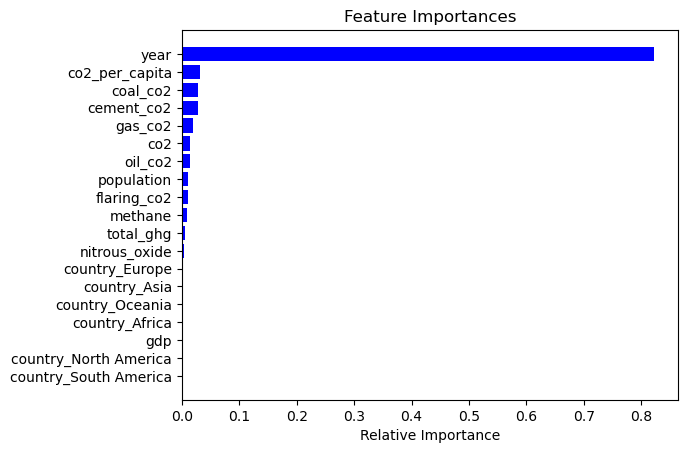

In [22]:
# Autre méthode avec matplotlib pour les features importances
importances = model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Prédiction jusqu'a 2100

In [23]:
sns.set_style("whitegrid")

In [24]:
# préparation du df pour prédiction
df_toPredict =  df.drop(['classes', 'temp_anomaly'] , axis=1) # suppression des variables non utilisé pour le modèle
df_toPredict = pd.get_dummies(df_toPredict, columns=data.select_dtypes(exclude=['int64', 'float64']).columns) # encodage des continents

# vérification que le nouveau df à le même nombre de features que X_test
if len(df_toPredict.columns) == len(X_test.columns):
    print("Nombre de colonnes identiques")
else:
    print("Nombres de colonnes différentes")

Nombre de colonnes identiques


In [25]:
# création d'une colonne de prédiction avec les données actuelle
df_toPredict["prediction"] = model.predict(df_toPredict)

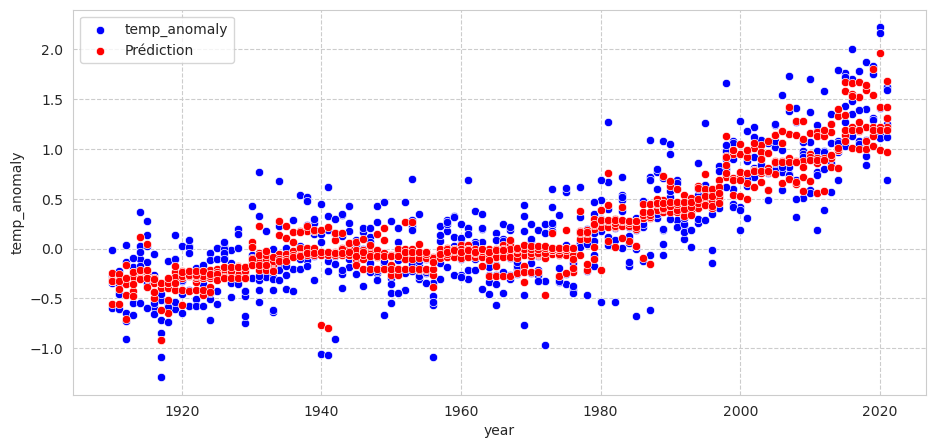

In [26]:
# comparaison de la target et des prédictions
plt.figure(figsize=(11, 5))
sns.scatterplot(data=df, x="year", y="temp_anomaly", color='b', label='temp_anomaly')
sns.scatterplot(data=df_toPredict, x="year", y="prediction", color='r', label='Prédiction')
plt.legend()
plt.grid(True, linestyle = '--')

Le modèle XGboost donne des prédictions assez proche de la cible

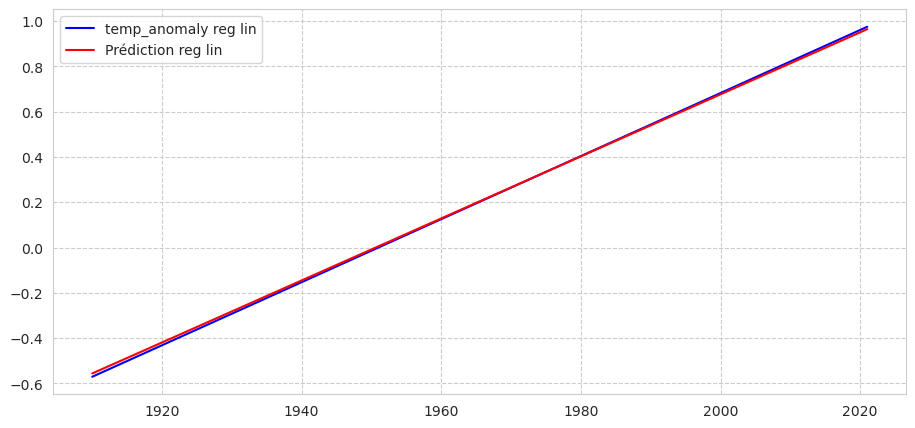

In [27]:
# maintenant essayons de faire une regression linéaire pour chaque série
from scipy.stats import linregress

# Régression linéaire pour temp_anomaly
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(df.year, df.temp_anomaly)
# Régression linéaire pour prediction
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(df_toPredict.year, df_toPredict.prediction)

# Tracé des droites de régression
plt.figure(figsize=(11, 5))
plt.plot(df.year, intercept1 + slope1 * df.year, 'blue', label='temp_anomaly reg lin')
plt.plot(df_toPredict.year, intercept2 + slope2 * df_toPredict.year, 'r', label='Prédiction reg lin')
plt.legend()
plt.grid(True, linestyle = '--');

Les régréssions linéaires de la target et des prédictions est assez similaire

In [28]:
# résultat des régréssion linéraire
target = {'data': "target", 'slope': slope1, 'intercept': intercept1, 'R²':r_value1, 'p_val':p_value1, 'std':std_err1}
predic = {'data': "prediction", 'slope': slope2, 'intercept': intercept2, 'R²':r_value2, 'p_val':p_value2, 'std':std_err2}
reg_result = pd.DataFrame([target, predic])
print(reg_result)
print("\nL'interception est proche et le R² est meilleur pour la prédiction donc attention à la std des valeurs en prédiction, toutefois la régression de la target et du modèle sont très proche")

         data  slope  intercept   R²  p_val  std
0      target   0.01     -27.18 0.77   0.00 0.00
1  prediction   0.01     -26.73 0.87   0.00 0.00

L'interception est proche et le R² est meilleur pour la prédiction donc attention à la std des valeurs en prédiction, toutefois la régression de la target et du modèle sont très proche


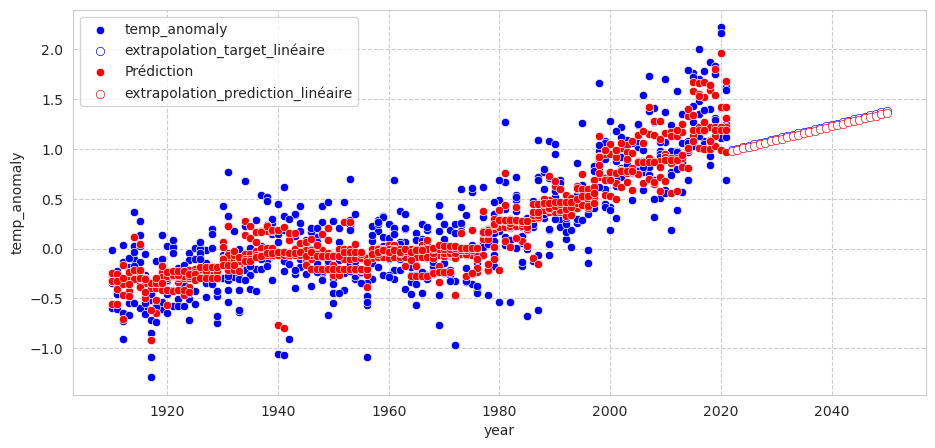

In [29]:
# création d'un array jusqu'en 2050 pour prédictions
years = np.arange(df.year.max()+1, 2051)

# Extrapolation des valeurs pour la série 1
extrapolated_y1 = intercept1 + slope1 * years
# Extrapolation des valeurs pour la série 2
extrapolated_y2 = intercept2 + slope2 * years

# comparaison de la target et des prédictions avec régréssion linéaire
plt.figure(figsize=(11, 5))
sns.scatterplot(data=df, x="year", y="temp_anomaly", color='b', label='temp_anomaly')
sns.scatterplot(x=years, y=extrapolated_y1, edgecolor='b',facecolor='white', label='extrapolation_target_linéaire')
sns.scatterplot(data=df_toPredict, x="year", y="prediction", color='r', label='Prédiction')
sns.scatterplot(x=years, y=extrapolated_y2, edgecolor='r', facecolor='white', label='extrapolation_prediction_linéaire')
plt.legend()
plt.grid(True, linestyle = '--');

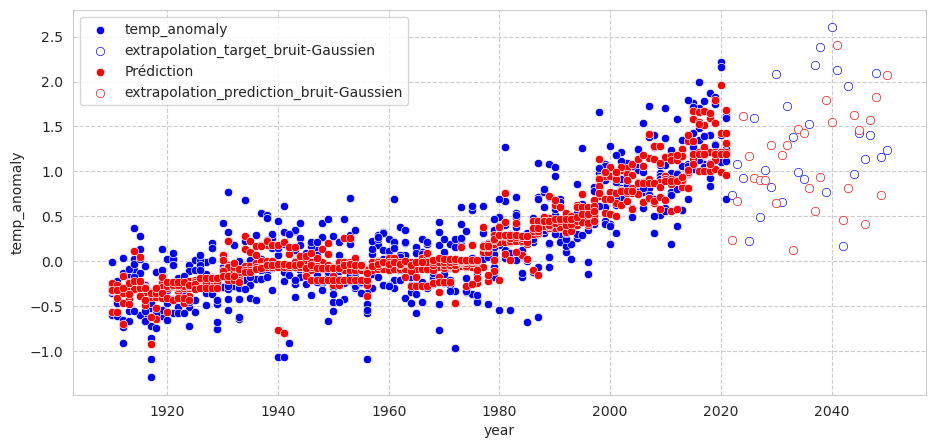

In [30]:
# Si on souhaite allé plus loin on peut ajouter du bruit gaussien pour avoir une variation des prédictions en fonction de
# la std des données de la target et prédiction

# Ajout du bruit gaussien sur target
std_dev = df.temp_anomaly.std()  # Écart-type du bruit gaussien
noise = np.random.normal(0, std_dev, size=len(years))
y_noise_target = extrapolated_y1 + noise

# Ajout du bruit gaussien sur prediction
std_dev = df_toPredict.prediction.std()  # Écart-type du bruit gaussien
noise = np.random.normal(0, std_dev, size=len(years))
y_noise_prediction = extrapolated_y2 + noise

# comparaison de la target et des prédictions avec bruit gaussien
plt.figure(figsize=(11, 5))
sns.scatterplot(data=df, x="year", y="temp_anomaly", color='b', label='temp_anomaly')
sns.scatterplot(x=years, y=y_noise_target, edgecolor='b',facecolor='white', label='extrapolation_target_bruit-Gaussien')
sns.scatterplot(data=df_toPredict, x="year", y="prediction", color='r', label='Prédiction')
sns.scatterplot(x=years, y=y_noise_prediction, edgecolor='r', facecolor='white', label='extrapolation_prediction_bruit-Gaussien')
plt.legend()
plt.grid(True, linestyle = '--');

### Conclusion

La feature "year" a le poids le plus important dans le modèle mais le cours du temps n'est pas la seule explication à l'augmentation de la température terrestre. Les autres features ont aussi leur importance mais semblent être incomplete pour expliquer tous les phénomènes sous-jacents à ces anomalies.
En outre, on observe à partir des années 80, une accélération du phénomène. Enfin, d'autres features pouvant compléter le dataset serait intéressant à analyser afin de compléter le modèle de prédiction.